2024-12-24 00:17:45,684 - INFO - Iniciando simulação Monte Carlo...
2024-12-24 00:17:45,685 - INFO - Processando lote 1/40
2024-12-24 00:17:45,691 - INFO - Processando lote 11/40
2024-12-24 00:17:45,694 - INFO - Processando lote 21/40
2024-12-24 00:17:45,697 - INFO - Processando lote 31/40
2024-12-24 00:17:45,703 - INFO - 
Simulação concluída em 0.02 segundos
2024-12-24 00:17:45,706 - INFO - 
Métricas Finais:
2024-12-24 00:17:45,707 - INFO - overall_mean: -0.196375
2024-12-24 00:17:45,708 - INFO - overall_std: 1.924063
2024-12-24 00:17:45,711 - INFO - min_value: -0.237430
2024-12-24 00:17:45,714 - INFO - max_value: -0.152248


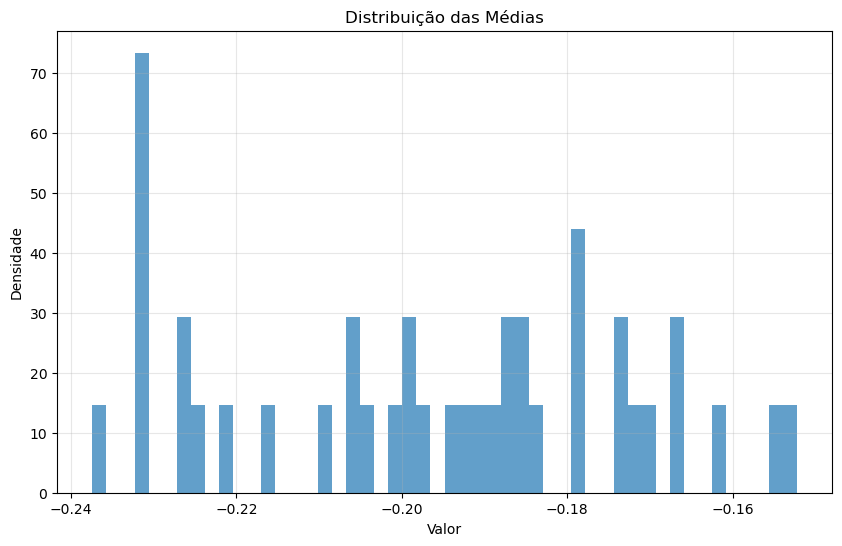

In [1]:
import numpy as np
from typing import List, Dict
import logging
from concurrent.futures import ThreadPoolExecutor
from queue import Queue
import time
import matplotlib.pyplot as plt

# Configuração de logging
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class SimulationConfig:
    """Configuração para simulação Monte Carlo"""
    def __init__(self):
        # Parâmetros ajustados para 20GB RAM
        self.n_simulations = 40000  # Reduzido para caber na memória
        self.batch_size = 1000      # Tamanho do lote para processamento
        self.n_variables = 4        # Número de variáveis
        self.confidence_level = 0.95
        self.optimization_target = 1.0

        # Parâmetros de memória
        self.max_memory_usage = 14 * 1024 * 1024 * 1024  # 14GB em bytes
        self.dtype = np.float32  # Usando float32 em vez de float64 para economia de memória

class Distribution:
    """Classe base para distribuições probabilísticas"""
    def sample(self, size: int) -> np.ndarray:
        raise NotImplementedError

    def params(self) -> dict:
        raise NotImplementedError

class OptimizedNormalDistribution(Distribution):
    """Distribuição normal otimizada para memória"""
    def __init__(self, mu: float, sigma: float, rng: np.random.Generator, dtype=np.float32):
        self.mu = mu
        self.sigma = sigma
        self.rng = rng
        self.dtype = dtype
        self._cached_samples = None
        self._cache_size = 5000  # Reduzido para economia de memória

    def sample(self, size: int) -> np.ndarray:
        if self._cached_samples is None or len(self._cached_samples) < size:
            self._cached_samples = self.rng.normal(
                self.mu, self.sigma, self._cache_size
            ).astype(self.dtype)

        result = self._cached_samples[:size]
        self._cached_samples = self._cached_samples[size:]
        return result

class MemoryAwareMonteCarloEngine:
    """Motor de simulação Monte Carlo com consciência de memória"""
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.rng = np.random.default_rng(seed=42)
        self.results_queue = Queue(maxsize=100)  # Limitado para controle de memória
        self.distributions = []
        self._initialize_distributions()

    def _initialize_distributions(self):
        """Inicializa distribuições com tipo de dados otimizado"""
        for _ in range(self.config.n_variables):
            mu = self.rng.normal(0, 1)
            sigma = self.rng.uniform(0.5, 2)
            self.distributions.append(
                OptimizedNormalDistribution(mu, sigma, self.rng, dtype=self.config.dtype)
            )

    def _simulate_batch(self, batch_size: int) -> np.ndarray:
        """Simula um lote de dados com controle de memória"""
        results = np.zeros((batch_size, len(self.distributions)), dtype=self.config.dtype)
        for i, dist in enumerate(self.distributions):
            results[:, i] = dist.sample(batch_size)
        return results

    def _process_batch(self, batch_data: np.ndarray) -> Dict[str, float]:
        """Processa resultados do lote"""
        return {
            'mean': float(np.mean(batch_data)),
            'std': float(np.std(batch_data)),
            'var': float(np.var(batch_data))
        }

    def run_simulation(self) -> List[Dict[str, float]]:
        """Executa simulação com controle de memória"""
        logger.info("Iniciando simulação Monte Carlo...")
        results = []

        n_batches = self.config.n_simulations // self.config.batch_size

        with ThreadPoolExecutor(max_workers=4) as executor:  # Limitado para controle de memória
            for batch_idx in range(n_batches):
                if batch_idx % 10 == 0:
                    logger.info(f"Processando lote {batch_idx + 1}/{n_batches}")

                batch_data = self._simulate_batch(self.config.batch_size)
                metrics = self._process_batch(batch_data)
                results.append(metrics)

                # Libera memória explicitamente
                del batch_data

        return results

class MemoryEfficientAnalyzer:
    """Analisador otimizado para uso de memória"""
    def __init__(self, results: List[Dict[str, float]], config: SimulationConfig):
        self.results = results
        self.config = config

    def compute_aggregate_metrics(self) -> Dict[str, float]:
        """Computa métricas agregadas de forma eficiente"""
        means = np.array([r['mean'] for r in self.results], dtype=self.config.dtype)
        stds = np.array([r['std'] for r in self.results], dtype=self.config.dtype)

        return {
            'overall_mean': float(np.mean(means)),
            'overall_std': float(np.mean(stds)),
            'min_value': float(np.min(means)),
            'max_value': float(np.max(means))
        }

    def plot_results(self):
        """Plota resultados de forma eficiente"""
        means = np.array([r['mean'] for r in self.results], dtype=self.config.dtype)

        plt.figure(figsize=(10, 6))
        plt.hist(means, bins=50, density=True, alpha=0.7)
        plt.title('Distribuição das Médias')
        plt.xlabel('Valor')
        plt.ylabel('Densidade')
        plt.grid(True, alpha=0.3)
        plt.show()

def main():
    # Configuração
    config = SimulationConfig()

    # Engine de simulação
    engine = MemoryAwareMonteCarloEngine(config)

    # Executa simulação
    start_time = time.time()
    results = engine.run_simulation()

    # Análise
    analyzer = MemoryEfficientAnalyzer(results, config)
    metrics = analyzer.compute_aggregate_metrics()

    # Resultados
    total_time = time.time() - start_time
    logger.info(f"\nSimulação concluída em {total_time:.2f} segundos")
    logger.info("\nMétricas Finais:")
    for key, value in metrics.items():
        logger.info(f"{key}: {value:.6f}")

    # Visualização
    analyzer.plot_results()

if __name__ == "__main__":
    main()